# Milestone Project 1: Food Vision Big

We'll use mixed precision to make model use float16 and float32 for faster learning. We need GPU that has Tensor Cores!

Additionaly, we'll use parallel computing and prefetch transformation to speed up preprocessing our data!

## Check GPU

For mixed precision training, there is Tesla T4!

**Score 7.0+**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a8a83d49-d089-2848-9208-20633e3c65ff)


## Get helper functions

In [2]:
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2024-01-15 18:37:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-15 18:37:45 (20.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # is our target dataset in the list

True


In [17]:
# Load in the data ( takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

We need:
* class names
* the shape of our input data (image tensors)
* the datatype of our input data
* What the labels look like ( one-hot encoded / label encoded )?
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)

In [ ]:
image

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

### Plot an image from TF Datasets

In [ ]:
# Plot
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"{class_names[label.numpy()]}")
plt.axis(False)

## Create preprocessing functions for our data
What are we going to change in our data:
* resize (same size of images)
* normalization (values of tensors between 0 & 1)
* tensor's datatype (`float32` or `float16` for mixed precision)
* making batches (all of the batches the in same size)

Since we're using EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image dtype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  #image = image/255. # efficientnet doesnt need that
  return tf.cast(image, tf.float32), label # return tuple of (float32_image, label)

In [ ]:
# Preprocess a single sample image
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

## Batch & prepare datasets

**tf.data API** allows to boost a pipeline!


GPU works on the current batch, and simultanously CPU prefetches the next batch!
Thanks to num_parallel_calls we can utilize all CPUs!

In [19]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) #.cache() - needs lots of memory

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".



## Create modelling callbacks

In [21]:
# Create tensorboard callback (import)
from helper_functions import create_tensorboard_callback

In [24]:
# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True, # only the model with best val_acc,
                                                      save_weights_only=True,
                                                      verbose=0)

In [25]:
tf.__version__

'2.15.0'

## Setup mixed precision training

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

Important to remember:
* training may utilize mixed precision, BUT...
* output layer has to have dtype=`float32` (numerical stability)

In [26]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision training

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [28]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we use our own input layer
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but not all the models have it
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision)

In [30]:
# Check the dtype_policy attributes of layers
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


* `layer.dtype` - the data type a layer stores its variables in
* `layer.dtype_policy` - the data type a layer computes in

In [33]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [34]:
# Fit the feature extraction model with callback
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7154 - accuracy: 0.5821

2368/2368 [==============================] - 196s 77ms/step - loss: 1.7154 - accuracy: 0.5821 - val_loss: 1.1297 - val_accuracy: 0.7034
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2005 - accuracy: 0.6875

2368/2368 [==============================] - 176s 73ms/step - loss: 1.2005 - accuracy: 0.6875 - val_loss: 1.0314 - val_accuracy: 0.7203
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0553 - accuracy: 0.7237

2368/2368 [==============================] - 178s 74ms/step - loss: 1.0553 - accuracy: 0.7237 - val_loss: 1.0020 - val_accuracy: 0.7251


In [35]:
model_feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 63s 80ms/step - loss: 1.0007 - accuracy: 0.7293


# FINE-TUNING

Callbacks:
* model_checkpoint
* early_stopping
* reduce_lr_on_plateau

In [36]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [37]:
loaded_model = tf.keras.models.load_model(save_dir)
loaded_model

In [38]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [39]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 56s 67ms/step - loss: 1.0007 - accuracy: 0.7293


[1.0007288455963135, 0.729346513748169]

In [40]:
#import numpy as np
#assert np.isclose(results_feature_extraction_model, results_loaded_saved_model).all()

In [41]:
for layer in loaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [42]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"])

In [43]:
# EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
history_101_food_classes_fine_tune = loaded_model.fit(train_data,
                                               epochs=100,
                                               steps_per_epoch=len(train_data),
                                               validation_data=test_data,
                                               validation_steps=int(0.15*len(test_data)),
                                               callbacks=[model_checkpoint,
                                                          early_stopping,
                                                          reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 436s 164ms/step - loss: 0.8741 - accuracy: 0.7641 - val_loss: 0.7441 - val_accuracy: 0.7966 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 355s 149ms/step - loss: 0.5392 - accuracy: 0.8514 - val_loss: 0.7654 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 3/100
1683/2368 [====================>.........] - ETA: 1:39 - loss: 0.3037 - accuracy: 0.9157

In [46]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 0.9085 - accuracy: 0.8052


[0.9084509015083313, 0.8051881194114685]

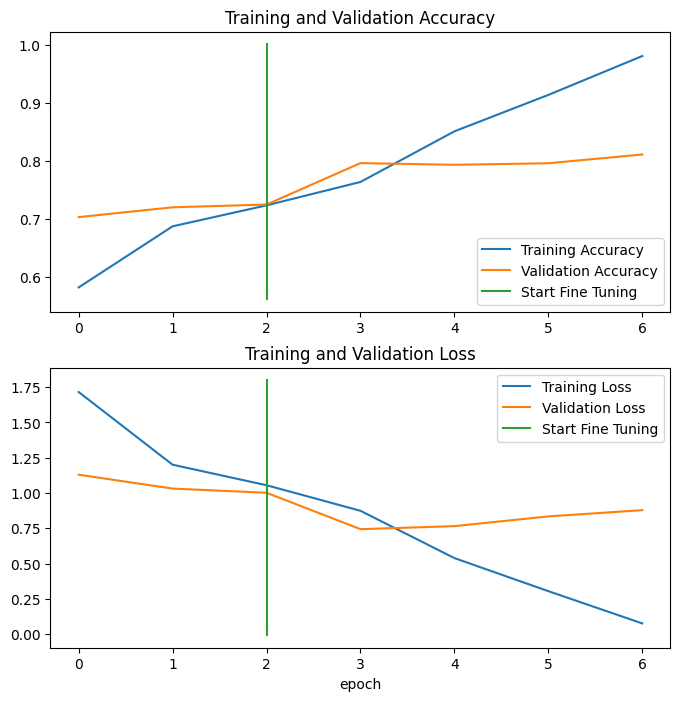

In [47]:
from helper_functions import compare_historys
compare_historys(history_101_food_classes_feature_extract, history_101_food_classes_fine_tune, initial_epochs=3)

In [48]:
loaded_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")